## Sequence Models

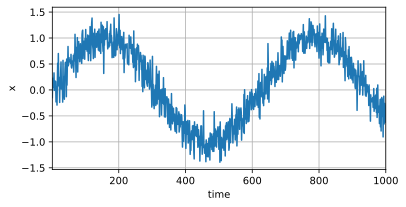

In [20]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

Given the past/recent data, and predict the future data.

And then map the original data to pairs, yt = xt, Xt = [xt-tau, ..., xt-1].

features are loop cut of x in number of tau, and labels are the last T-tau of x.

In [21]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

Now we transform the sequence problem to a regression problem.

In [22]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(tau, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

Then we can train the data

In [23]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.073307
epoch 2, loss: 0.059066
epoch 3, loss: 0.062111
epoch 4, loss: 0.056008
epoch 5, loss: 0.055429


Next we can predict.

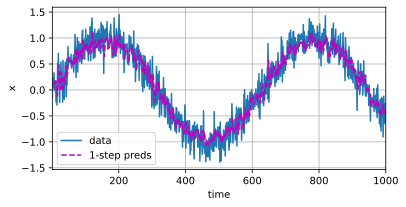

In [24]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, T],
         figsize=(6, 3))

通常，对于直到 xt 的观测序列，其在时间步 t+k 处的预测输出 x^t+k^ 称为 k 步预测（ k -step-ahead-prediction）。
由于我们的观察已经到了 x^604^，它的 k 步预测是 x^604+k^。 换句话说，我们必须使用我们自己的预测（而不是原始数据）来进行多步预测。让我们看看效果如何。

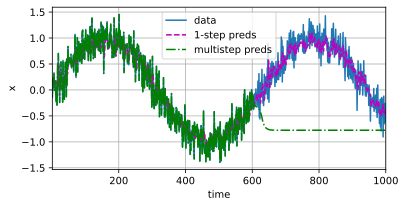

In [28]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, T], figsize=(6, 3))

如上面的例子所示，绿线的预测显然并不理想。 经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。 为什么这个算法效果这么差呢？
事实是由于错误的累积： 假设在步骤 1 之后，我们积累了一些错误 ϵ1=ϵ¯ 。 于是，步骤 2 的输入被扰动了 ϵ1 ， 结果积累的误差是依照次序的 ϵ2=ϵ¯+cϵ1 ，
其中 c 为某个常数，后面的预测误差依此类推。 因此误差可能会相当快地偏离真实的观测结果。 例如，未来 24 小时的天气预报往往相当准确， 但超过这一点，精度就会迅速下降。

基于 k=1,4,16,64 ，通过对整个序列预测的计算， 让我们更仔细地看一下 k 步预测的困难。

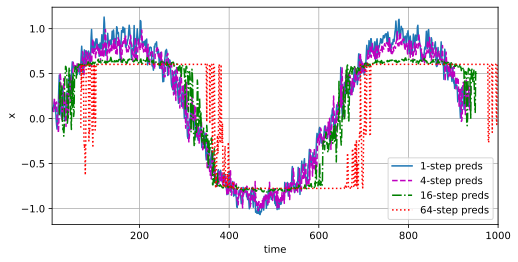

In [30]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(8, 4))